In [573]:
import pandas as pd
import glob
import os


In [549]:
kcutoffs = pd.read_csv('ko_list', sep='\t', index_col=0)
llist = ['Teuk', 'Geuk', 'Tbact', 'Gbact']

ev_dict = {}
for ev in glob.glob('downloads/K00011/*/environmental_parameters.csv'):
    dd = pd.read_csv(ev, sep='\t', index_col='sample_ID')
    ev_dict[ev] = dd
env_params = pd.concat(ev_dict).reset_index().drop('level_0', axis=1).set_index('sample_ID')
env_params = env_params.drop_duplicates(keep='first')

In [489]:
aln_dict = {}
full_dict = {}
ndict  = {}
for lk in glob.glob('downloads/K*'):
    fdict = {}
    ndict = {} 
    k = os.path.basename(lk)
    cutoff = float(kcutoffs.loc[k, 'threshold'])
    for t in llist:
        f = os.path.join(lk, t, '_'.join([k, t, 'aln_result.tsv']))
        df = pd.read_csv(f, skiprows=8, sep = '\t', index_col=1)
        if 'euk' in t:
            df.index = df.index.str.split("_").str[0:2].str.join('_')    
        passing_genes = df[df.bit_score>cutoff]
        ndict[t] = passing_genes.index
        fdict[t] = df.index
    aln_dict[k] = ndict
    full_dict[k] = fdict

In [490]:
ndict = {}
abund_dict = {}
for lk in glob.glob('downloads/K*'):
    ndict = {}
    k = os.path.basename(lk)
    for t in llist:
        f = os.path.join(lk, t, 'abundance_matrix.csv')
        df = pd.read_csv(f, sep ='\t', header = 0, skiprows=1, index_col=0)
        ndict[t]=df
    abund_dict[k] = ndict

In [491]:
subset_abund = {}
for lk in glob.glob('downloads/K*'):
    k = os.path.basename(lk)
    ndict = {}
    for t in llist:
        subset = set(abund_dict[k][t].index).intersection(aln_dict[k][t])
        aa = abund_dict[k][t].loc[subset]
        ndict[t]=aa
    subset_abund[k]=ndict

In [853]:
total_counts = pd.DataFrame(index = full_dict.keys(), columns = ['MATOU', 'OM-RGC'] )
for key in full_dict:
    for t in full_dict[key]:
        if 'euk' in t:
            euk = len(full_dict[key][t])
        else:
            bact = len(full_dict[key][t])
    total_counts.loc[key, 'MATOU']=euk
    total_counts.loc[key, 'OM-RGC']=bact

In [854]:
total_counts

,MATOU,OM-RGC
K00130,52672,69831
K17742,45896,154362
K10227,123,1864
K00008,20555,43624
K08261,44855,152543
K17755,7629,19487
K00544,9705,7613
K00011,37518,4645
K19270,3590,7923
K05847,56060,270879


In [272]:
K = 'K02002'

def count_taxa(K, dtype='Tbact'):
    df = subset_abund[K][dtype]
    t = df.groupby('taxonomy').count().iloc[:,0].sort_values(ascending=False)
    t=pd.DataFrame(t)
    t.columns = ['count']
    return(t)
# taxa = df.taxonomy.str.split(';', expand = True)
# df.merge(taxa, left_index=True, right_index=True)

In [273]:
subset_abund_taxa_gbact = {}
for k in subset_abund.keys():
    subset_abund_taxa_gbact[k] = count_taxa(k, )

In [274]:
subset_abund_taxa_teuk = {}
for k in subset_abund.keys():
    subset_abund_taxa_teuk[k] = count_taxa(k, dtype='Teuk')

In [277]:
subset_abund_taxa_gbact['K02001']

,count
taxonomy,
Biota; Bacteria; Proteobacteria,1283
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodobacterales; Rhodobacteraceae,374
Biota; Bacteria; Proteobacteria; Alphaproteobacteria,356
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Pelagibacterales; Pelagibacteraceae; Candidatus Pelagibacter,344
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Pelagibacterales; Pelagibacteraceae,295
...,...
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodobacterales; Rhodobacteraceae; Jannaschia,1
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodobacterales; Rhodobacteraceae; Aliiroseovarius; Aliiroseovarius crassostreae,1
Biota; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Rhodobiaceae; Parvibaculum; Parvibaculum lavamentivorans,1


In [291]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

In [287]:

subset_abund['K02001']['Tbact'].drop('taxonomy', axis=1).sum().sort_values()

TARA_B100000444    0.000015
TARA_B100000959    0.000017
TARA_B100001107    0.000017
TARA_B100001010    0.000018
TARA_B100000133    0.000018
                     ...   
TARA_B110001437    0.000155
TARA_B110000966    0.000169
TARA_B110001435    0.000169
TARA_B110000085    0.000196
TARA_B100000120    0.000469
Length: 187, dtype: float64

In [425]:
df = pd.read_csv('../input/Osmolyte-Reactions.tsv', sep='\t')
df.ORTHOLOGY = df.ORTHOLOGY.str.split(';')
df = df[df['ORTHOLOGY'].notna()]
df['COMBINED_ORTHO'] = df[['NAMED_GROUP', 'PATHWAY']].astype(str).agg(':'.join, axis=1)
df['COMBINED_ORTHO_STEP'] = df[['NAMED_GROUP', 'PATHWAY', 'STEP']].astype(str).agg(':'.join, axis=1)
df['max_step']= df.groupby('COMBINED_ORTHO')['STEP'].transform('max')
df['ALLKO']=df.groupby('COMBINED_ORTHO_STEP')['ORTHOLOGY'].transform(sum)

#Subset the DF to just columns that we will be using
subset_df = df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP', 'ALLKO', 'max_step']]
subset_df = subset_df.loc[subset_df[['COMPOUND_NAME','COMPOUND','BROAD', 'NAMED_GROUP', 'COMBINED_ORTHO','COMBINED_ORTHO_STEP']].drop_duplicates().index]

metabolite_dict = pd.read_csv('../input/types.csv')[['metabolite', 'gentype']].set_index('metabolite').to_dict()['gentype']
#Index by KOs in an explosive fashion
ko_indexed = subset_df.explode('ALLKO').set_index('ALLKO')
ko_indexed['TYPE'] = ko_indexed.COMPOUND_NAME.map(metabolite_dict)

In [442]:
ko_indexed

,COMPOUND_NAME,COMPOUND,BROAD,NAMED_GROUP,COMBINED_ORTHO,COMBINED_ORTHO_STEP,max_step,TYPE
ALLKO,,,,,,,,
K00864,Glycerol,C00116,BREAKDOWN,Glycerol breakdown to sn-Glycerol 3-phosphate,Glycerol breakdown to sn-Glycerol 3-phosphate:1,Glycerol breakdown to sn-Glycerol 3-phosphate:1:1,1,Sugar alcohol
K00863,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05878,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05879,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
K05881,Glycerol,C00116,BREAKDOWN,Glycerol breakdown Glycerone phosphate,Glycerol breakdown Glycerone phosphate:1,Glycerol breakdown Glycerone phosphate:1:2,2,Sugar alcohol
...,...,...,...,...,...,...,...,...
K10674,Ectoine,C06231,BREAKDOWN,Ectoine transformation to 5-Hydroxyectoine,Ectoine transformation to 5-Hydroxyectoine:1,Ectoine transformation to 5-Hydroxyectoine:1:1,1,Amino acid
K15783,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:1,3,Amino acid
K15784,Ectoine,C06231,BREAKDOWN,Ectoine recycling,Ectoine recycling:1,Ectoine recycling:1:2,3,Amino acid


In [378]:
def get_all_genes_summed(dtype='Tbact'):
    dict_k = {}
    for k in subset_abund.keys():
        kdf = pd.DataFrame(subset_abund[k][dtype].drop('taxonomy', axis=1).sum().sort_values())
        kdf.columns = [k]
        dict_k[k] = kdf
    bigd = pd.concat(dict_k, axis = 1)
    bigd.columns = bigd.columns.get_level_values(0)
    return(bigd)

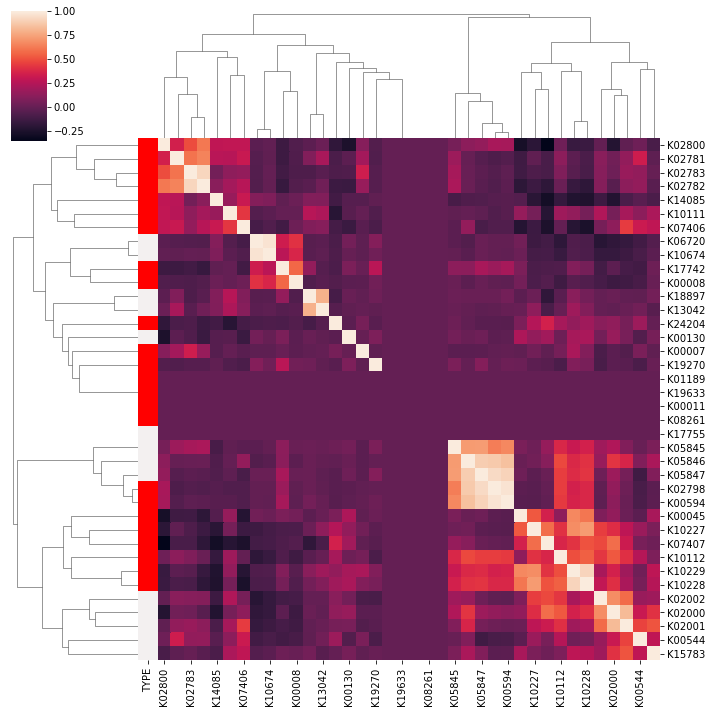

In [526]:
Tbact_summed = get_all_genes_summed()

def corr_data(Tbact_summed):
    Tbact_summed_corr = Tbact_summed.corr('pearson')
    type_mol = pd.DataFrame(ko_indexed.loc[Tbact_summed.corr().index].TYPE).reset_index().drop_duplicates().sort_values('ALLKO').replace('Sugar', 'Sugar alcohol').drop_duplicates().set_index('ALLKO')
    type_col = type_mol.to_dict()['TYPE']
    Tbact_summed_corr['TYPE'] = Tbact_summed_corr.index.map(type_col)
    network_pal = sns.light_palette('red', len(Tbact_summed_corr.TYPE.unique()))
    network_lut = dict(zip(Tbact_summed_corr.TYPE.unique(), network_pal))
    network_colors = pd.Series(Tbact_summed_corr.TYPE).map(network_lut)
    # Teuk_summed = get_all_genes_summed(dtype='Teuk')
    sns.clustermap(Tbact_summed_corr.fillna(0)[Tbact_summed_corr.index], row_colors=network_colors)
    return(Tbact_summed_corr)

Tbact_summed_corr = corr_data(Tbact_summed)

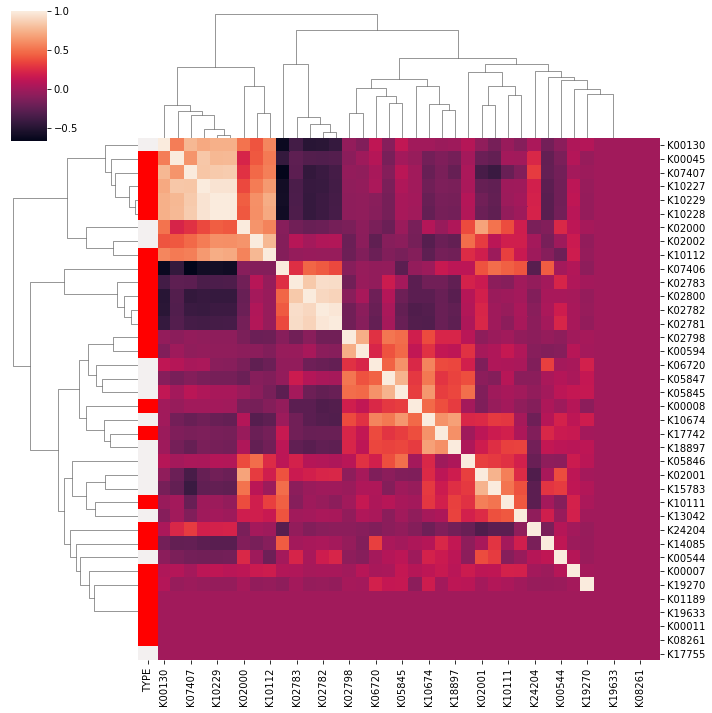

In [524]:

Gbact_summed = get_all_genes_summed(dtype='Gbact')

Gbact_summed_corr = corr_data(Gbact_summed)

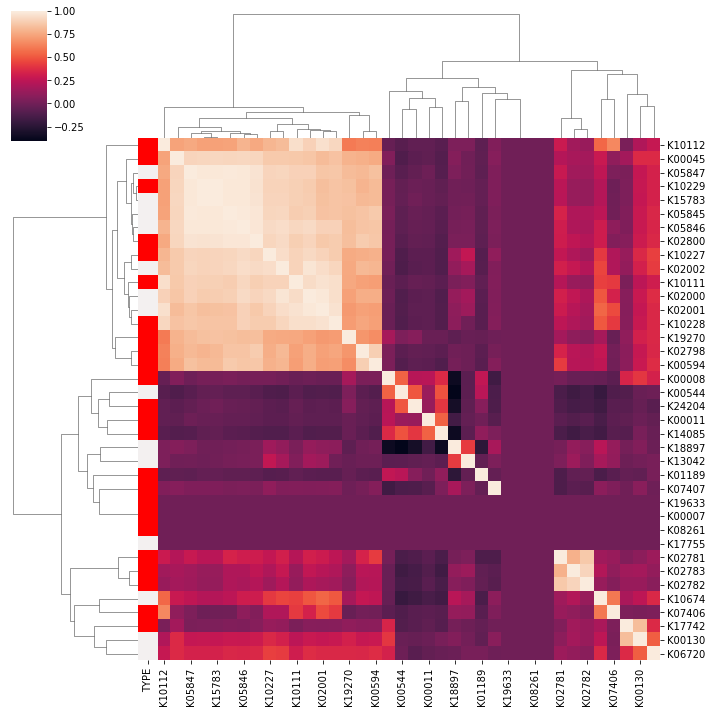

In [527]:
Teuk_summed = get_all_genes_summed(dtype='Teuk')

Teuk_summed_corr = corr_data(Teuk_summed)

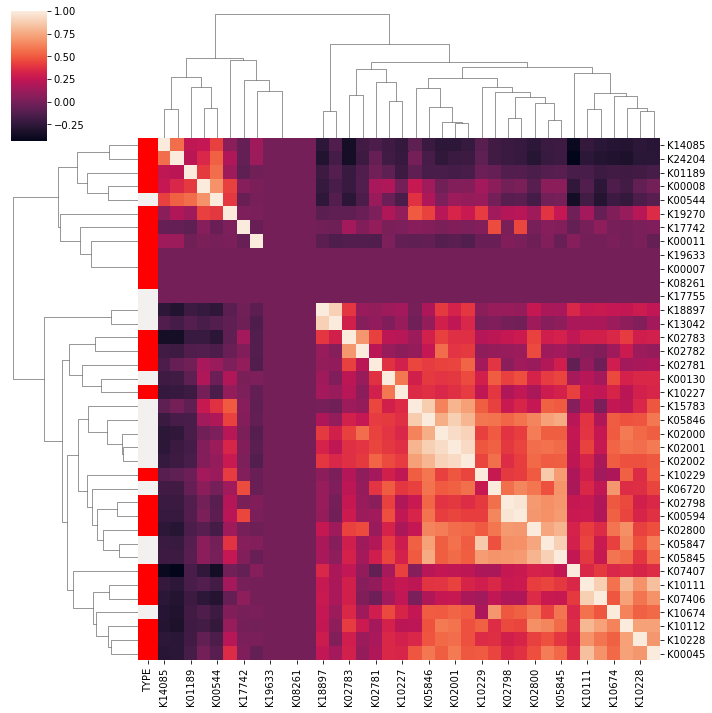

In [528]:
Geuk_summed = get_all_genes_summed(dtype='Geuk')

Geuk_summed_corr = corr_data(Geuk_summed)

In [443]:
pd.DataFrame(ko_indexed.loc[Tbact_summed.corr().index].BROAD).reset_index().drop_duplicates().sort_values('ALLKO')

,ALLKO,BROAD
51,K00007,BREAKDOWN
49,K00007,SYNTHESIS
7,K00008,SYNTHESIS
8,K00008,BREAKDOWN
15,K00011,BREAKDOWN
17,K00011,SYNTHESIS
70,K00045,SYNTHESIS
72,K00045,BREAKDOWN
0,K00130,SYNTHESIS
13,K00544,BREAKDOWN


In [333]:
def compare_scatter(k1, k2, dtype='Tbact'):
    a = pd.DataFrame(subset_abund[k1][dtype].drop('taxonomy', axis=1).sum().sort_values())
    a.columns = [k1]
    b =  pd.DataFrame(subset_abund[k2][dtype].drop('taxonomy', axis=1).sum().sort_values())
    b.columns = [k2]
    c = a.merge(b, left_index=True, right_index=True).plot(kind='scatter', x=k1, y=k2)
    return(c)


<AxesSubplot:xlabel='K02001', ylabel='K02002'>

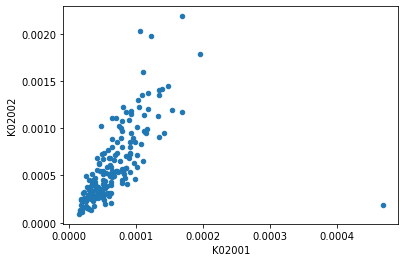

In [328]:
compare_scatter('K02001', 'K02002')

<AxesSubplot:xlabel='K02001', ylabel='K02000'>

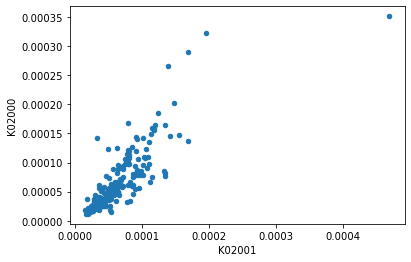

In [331]:
compare_scatter('K02001', 'K02000')

<AxesSubplot:xlabel='K02001', ylabel='K10229'>

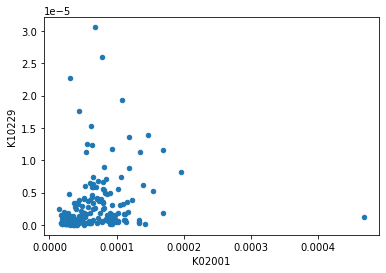

In [332]:
compare_scatter('K02001', 'K10229')

In [565]:
Tbact_summed_env = Tbact_summed.merge(env_params, left_index=True, right_index=True, how='left')
Tbact_summed_env = Tbact_summed_env[~Tbact_summed_env.index.duplicated(keep='first')]
list(Tbact_summed_env.columns)

['K00130',
 'K17742',
 'K10227',
 'K00008',
 'K08261',
 'K17755',
 'K00544',
 'K00011',
 'K19270',
 'K05847',
 'K06720',
 'K10229',
 'K05845',
 'K02798',
 'K02000',
 'K02001',
 'K02002',
 'K14085',
 'K10111',
 'K18897',
 'K00007',
 'K02783',
 'K24204',
 'K10674',
 'K15783',
 'K07406',
 'K19633',
 'K10228',
 'K02782',
 'K10112',
 'K05846',
 'K00045',
 'K00594',
 'K01189',
 'K02781',
 'K07407',
 'K02800',
 'K13042',
 'OGA_ID',
 'station',
 'depth',
 'size fraction',
 'latitude',
 'longitude',
 'OGA_ID.1',
 'Station',
 'ENA_ID',
 'INSDC_ID',
 'BioSamples_ID',
 'Sample_method',
 'Depth_Nominal',
 'Environmental_feature',
 'Fraction_Lower (µm)',
 'Fraction_Upper (µm)',
 'Biome',
 'Region',
 'Province',
 'Barcode',
 'Date_Time',
 'Seafloor (m)',
 'Temperature (°C)',
 'Salinity (PSU)',
 'Density (kg/m**3)',
 'Distance_coast (km)',
 'Chlorophyll_A (mg/m**3)',
 'Depth (m)',
 'PAR (mol quanta/m**2/day)',
 'O2 (µmol/kg)',
 'NO3 (µmol/l)',
 'Iron_5m* (µmol/l)',
 'Ammonium_5m* (µmol/l)',
 'Nitrite_

,K00130,K17742,K10227,K00008,K08261,K17755,K00544,K00011,K19270,K05847,...,Zeaxanthin (mg/m**3),Lutein (mg/m**3),Latitude (-),Longitude (-),Sea_ice* (%),Season,Season_subperiod,Okubo-Weiss* (-),Lyapunov* (l/day),Residence_time* (days)
TARA_A100000165,0.000012,0.000000e+00,0.000029,0.000000e+00,0.0,0.0,0.000016,0.0,0.0,9.245461e-07,...,0.05410,0.0000,35.7590,14.2574,0.0,autumn,middle,-0.124391,0.066158,15.222222
TARA_A100000220,0.000003,0.000000e+00,0.000100,0.000000e+00,0.0,0.0,0.000079,0.0,0.0,3.217718e-06,...,NaN,NaN,34.2116,13.7684,0.0,autumn,middle,0.007018,0.078478,1.777778
TARA_A100001026,0.000004,4.271605e-07,0.000040,2.361691e-06,0.0,0.0,0.000011,0.0,0.0,2.945959e-06,...,0.10320,0.0000,23.3600,37.2183,0.0,winter,early,-0.014886,NaN,0.000000
TARA_A100001195,0.000002,0.000000e+00,0.000017,0.000000e+00,0.0,0.0,0.000007,0.0,0.0,1.691999e-06,...,0.20015,0.0000,21.9467,38.2517,0.0,winter,early,0.450777,0.000000,0.000000
TARA_A100001401,0.000002,0.000000e+00,0.000027,1.558209e-07,0.0,0.0,0.000012,0.0,0.0,1.783539e-06,...,0.13445,0.0000,27.1600,34.8350,0.0,winter,early,0.162621,0.028165,1.194444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARA_B110000975,0.000006,0.000000e+00,0.000058,3.516356e-08,0.0,0.0,0.000013,0.0,0.0,4.966721e-06,...,0.00380,0.0006,71.0704,174.9916,0.0,summer,late,NaN,0.000000,0.000000
TARA_B110001435,0.000024,0.000000e+00,0.000334,0.000000e+00,0.0,0.0,0.000028,0.0,0.0,5.975517e-06,...,0.00850,0.0007,54.5305,-16.9377,0.0,spring,early,0.157922,0.101888,0.000000
TARA_B110001444,0.000010,0.000000e+00,0.000088,0.000000e+00,0.0,0.0,0.000023,0.0,0.0,3.882984e-06,...,0.00295,0.0000,67.1410,0.2355,0.0,spring,late,0.189385,0.121118,0.000000
TARA_B110001467,0.000012,0.000000e+00,0.000137,0.000000e+00,0.0,0.0,0.000002,0.0,0.0,4.667832e-07,...,NaN,NaN,76.1825,1.3918,0.0,spring,late,-0.007624,0.058176,3.277778


In [867]:
compound_dict = {}
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= sorted(list(set(n.index)))
    
def Kplot_maps_overlay(Tbact_summed_env, K='K00130', scale = 10e5):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
        
    for depth, color in zip(['SRF', 'DCM', 'MES'], ['green', 'blue', 'red']):
        subset = Tbact_summed_env[Tbact_summed_env['depth']==depth]
        ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[K]*scale, transform=ccrs.PlateCarree(), alpha=0.5,color=color)
    plt.show()
    
def Kplot_maps_subplot(Tbact_summed_env, Klist=['K00130'], kname='test', scale = 10e5, color='blue', depth_list = ['SRF', 'DCM', 'MES']):
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(len(Klist), 3)
    for i, k in enumerate(Klist):
        for j,d in enumerate(depth_list):
            subset = Tbact_summed_env[Tbact_summed_env['depth']==d]
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
            ax.coastlines()
            ax.scatter(x =subset.longitude, y=subset.latitude, 
               s= subset[k]*scale, transform=ccrs.PlateCarree(), alpha=0.8,color=color)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            if j == 0:
                ax.text(-350,1, k, fontsize=14)

            if i ==0:
                ax.set_title(d)

    plt.savefig(kname+'_Tbact.pdf')
    return()

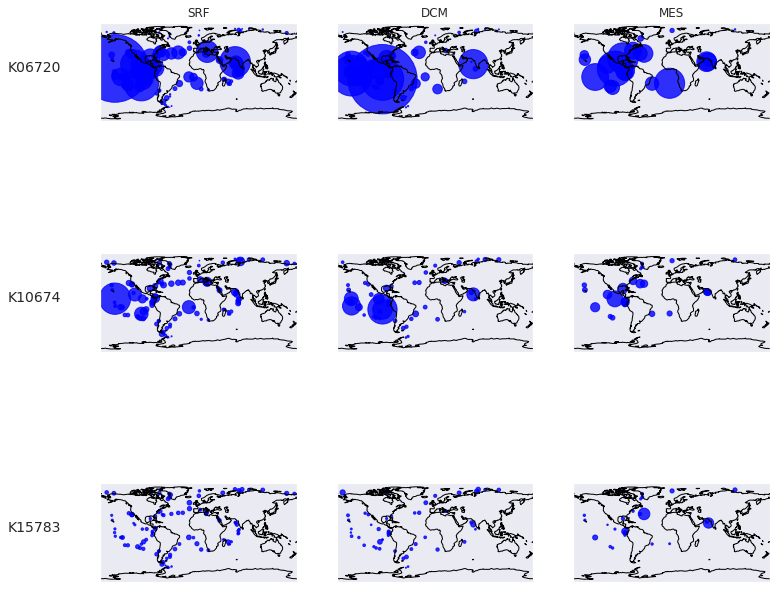

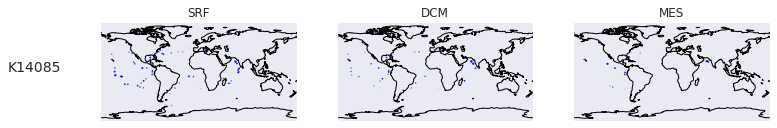

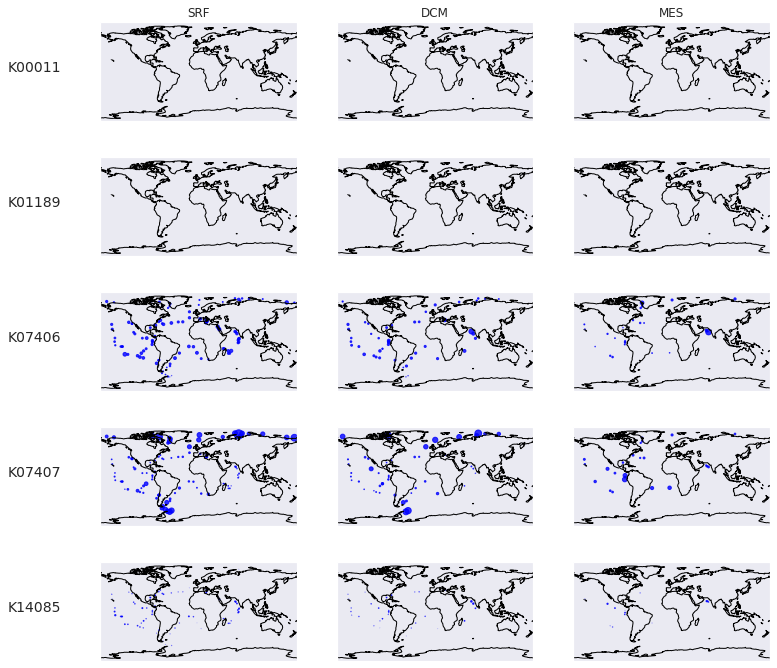

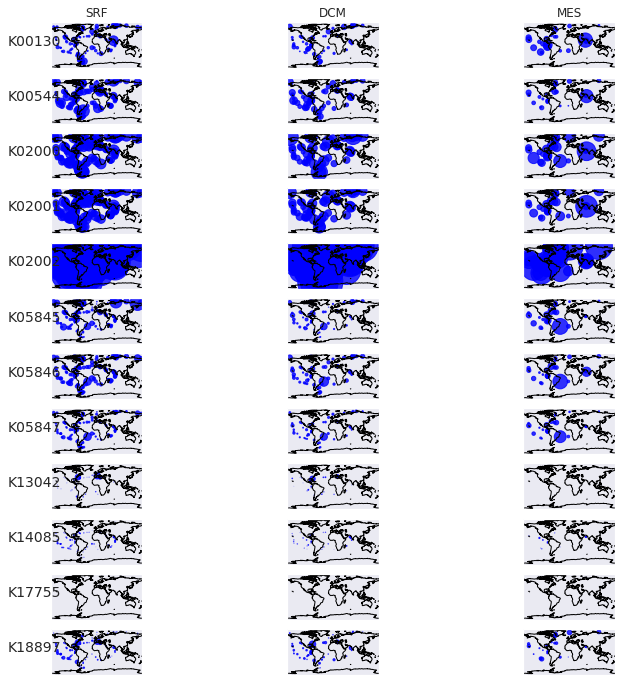

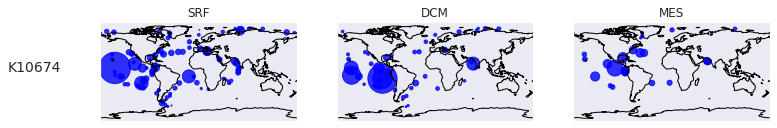

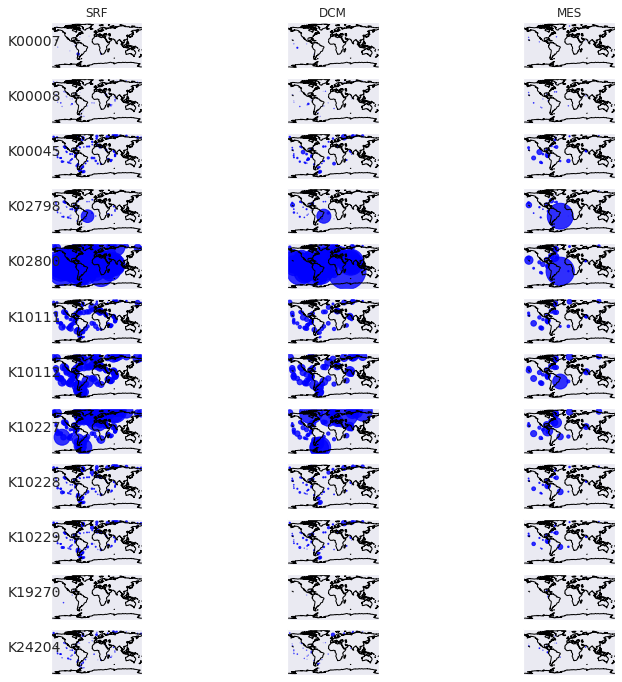

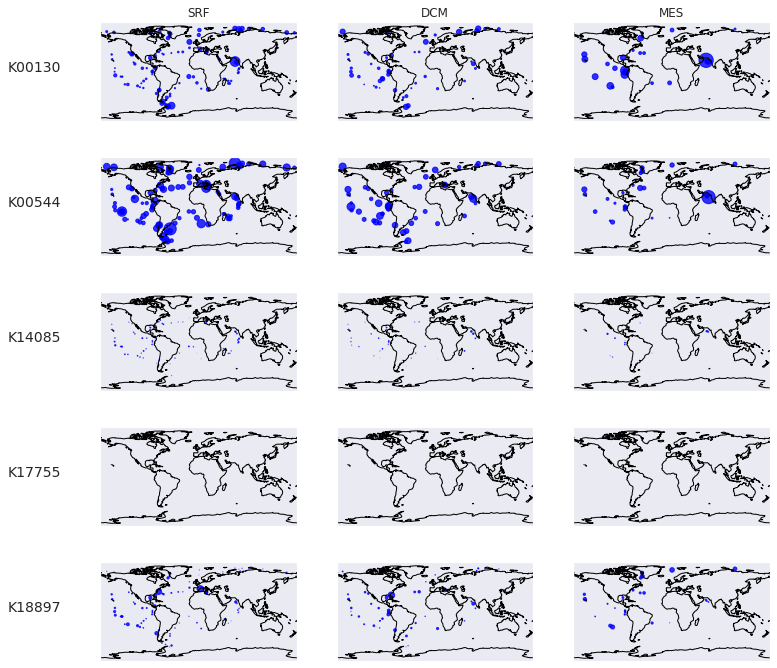

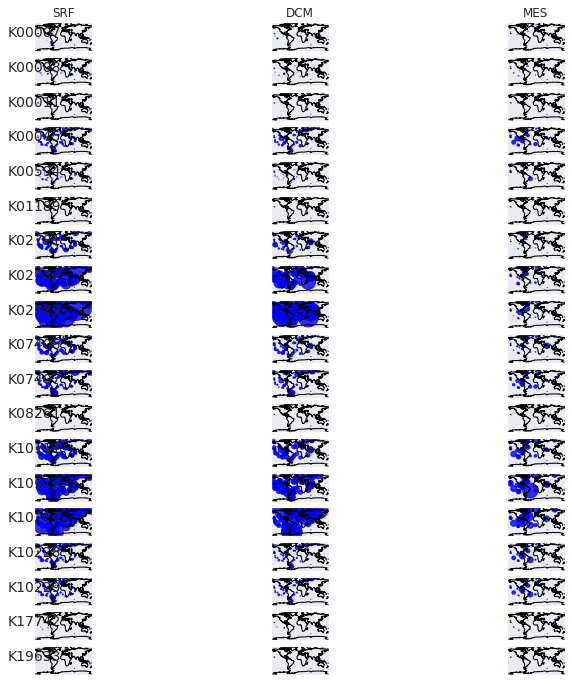

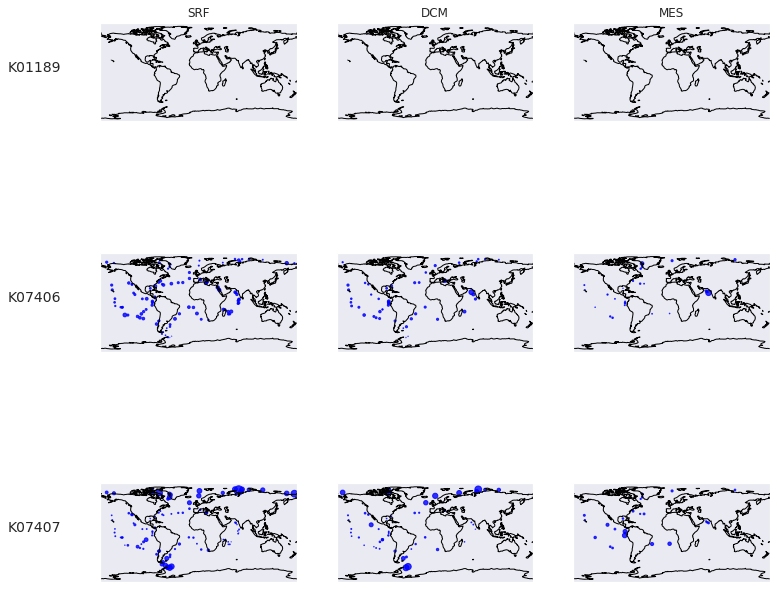

In [868]:
for compound in compound_dict:
    
    Kplot_maps_subplot(Tbact_summed_env, Klist=compound_dict[compound], kname=compound)

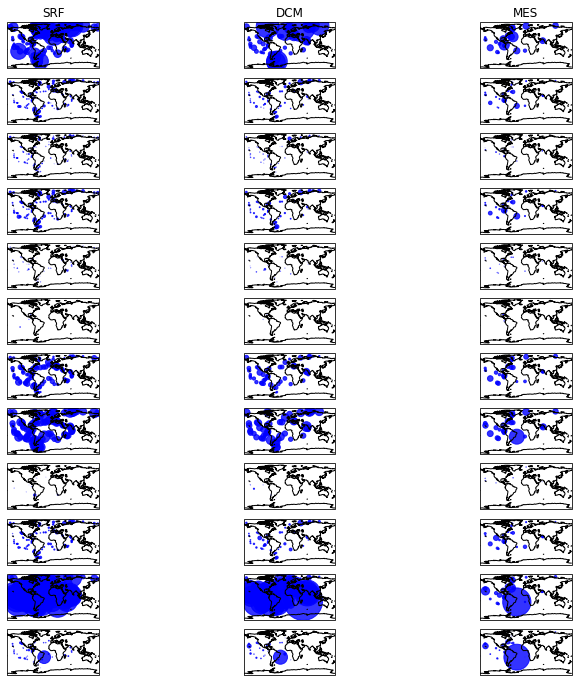

In [641]:
Kplot_maps_subplot(Tbact_summed_env, Klist=compound_dict['Mannitol'] )

In [ ]:
Kplot_maps_subplot(Tbact_summed_env, Klist=compound_dict['Mannitol'] )

In [642]:
for g, n in ko_indexed.loc[Tbact_summed.columns].groupby('COMPOUND_NAME'):
    compound_dict[g]= set(n.index)


dict_keys(['Ectoine', 'GABA', 'Glycerol', 'Glycine betaine', 'Hydroxyectoine', 'Mannitol', 'Sarcosine', 'Sorbitol', 'Sucrose'])

In [829]:
bd_groups = {}
for group, df in ko_indexed.groupby(['COMPOUND_NAME', 'BROAD']):
    bd_groups[group]= sorted(list(set(df.index)))
    

{('DMSP', 'BREAKDOWN'): ['K16953', 'K17486'],
 ('Ectoine', 'BREAKDOWN'): ['K10674', 'K15783', 'K15784', 'K15785'],
 ('Ectoine', 'SYNTHESIS'): ['K00003',
  'K00133',
  'K00836',
  'K00928',
  'K06718',
  'K06720'],
 ('GABA', 'BREAKDOWN'): ['K00135',
  'K00139',
  'K00613',
  'K00823',
  'K05604',
  'K07250',
  'K08324',
  'K08660',
  'K13524',
  'K14268',
  'K14755',
  'K16871',
  'K17761'],
 ('GABA', 'SYNTHESIS'): ['K00128',
  'K00137',
  'K00149',
  'K00274',
  'K00316',
  'K00657',
  'K00823',
  'K01426',
  'K01580',
  'K03343',
  'K07250',
  'K09251',
  'K09470',
  'K09471',
  'K09472',
  'K09473',
  'K11182',
  'K12252',
  'K12253',
  'K12254',
  'K12255',
  'K12256',
  'K13366',
  'K13524',
  'K14085',
  'K14268',
  'K14755',
  'K16871',
  'K18118',
  'K18119',
  'K21639'],
 ('Glutamate', 'BREAKDOWN'): ['K00260',
  'K00261',
  'K00262',
  'K00264',
  'K00265',
  'K00266',
  'K00284',
  'K00603',
  'K00618',
  'K00619',
  'K00620',
  'K00681',
  'K00764',
  'K00815',
  'K00832',
  

In [731]:
GBsets = [('Glycine betaine', 'BREAKDOWN'), ('Glycine betaine', 'SYNTHESIS'), ('Glycine betaine', 'TRANSPORT')]
Msets = [('Mannitol', 'BREAKDOWN'), ('Mannitol', 'SYNTHESIS'), ('Mannitol', 'TRANSPORT'),]

In [863]:
sns.set(rc={'figure.figsize':(20,10)})

def create_box_plot(Tbact_summed, compound = 'Glycine betaine', colors = ['#6E8A0F','#A1A1A1']):
    Trans = Tbact_summed[bd_groups[(compound, 'TRANSPORT')]]
    Syn = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'SYNTHESIS')])]
    BD = Tbact_summed[Tbact_summed.columns.intersection(bd_groups[(compound, 'BREAKDOWN')])]
    SynBD = Syn.merge(BD, left_index = True, right_index=True, how='inner')
    print(SynBD.columns)
    cdict = {}
    for t, c in zip([Trans, SynBD], colors):
        for k in t.columns:
            cdict[k]=c
    tt = Trans.merge(SynBD, left_index=True, right_index=True)
    g = sns.boxplot(data = tt,palette=cdict)
    g.set_yscale('log')
    return(tt)

Index(['K00130', 'K17755', 'K14085', 'K18897', 'K13042', 'K00544'], dtype='object')


,K02000,K02001,K02002,K05845,K05846,K05847,K00130,K17755,K14085,K18897,K13042,K00544
TARA_B100000267,0.000017,0.000026,0.000497,7.389564e-06,0.000008,0.000004,4.067313e-07,0.0,4.486838e-07,4.428186e-07,0.000000e+00,0.000008
TARA_B100000987,0.000032,0.000031,0.000276,6.271061e-07,0.000003,0.000001,4.290216e-07,0.0,6.265865e-09,2.574594e-07,0.000000e+00,0.000018
TARA_B100000900,0.000055,0.000090,0.001087,2.423461e-06,0.000006,0.000001,5.097897e-07,0.0,3.854322e-07,8.500139e-07,1.119762e-07,0.000024
TARA_B100000674,0.000020,0.000033,0.000391,7.538728e-07,0.000005,0.000001,5.611108e-07,0.0,7.503860e-07,1.506345e-06,0.000000e+00,0.000013
TARA_B100000943,0.000026,0.000052,0.000409,4.296538e-06,0.000004,0.000001,5.803048e-07,0.0,0.000000e+00,1.048444e-06,0.000000e+00,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...
TARA_B100000787,0.000110,0.000110,0.001348,8.406983e-07,0.000005,0.000003,4.599792e-05,0.0,6.762299e-08,1.931567e-06,0.000000e+00,0.000013
TARA_B100000954,0.000062,0.000036,0.000332,1.170063e-06,0.000004,0.000002,5.633296e-05,0.0,3.952442e-07,2.043331e-06,0.000000e+00,0.000011
TARA_B100000929,0.000045,0.000030,0.000453,4.856151e-05,0.000025,0.000020,8.338211e-05,0.0,1.556556e-08,2.149240e-06,0.000000e+00,0.000001
TARA_B100000090,0.000145,0.000142,0.000955,6.130616e-06,0.000013,0.000005,9.447701e-05,0.0,1.075215e-06,2.631373e-08,0.000000e+00,0.000049


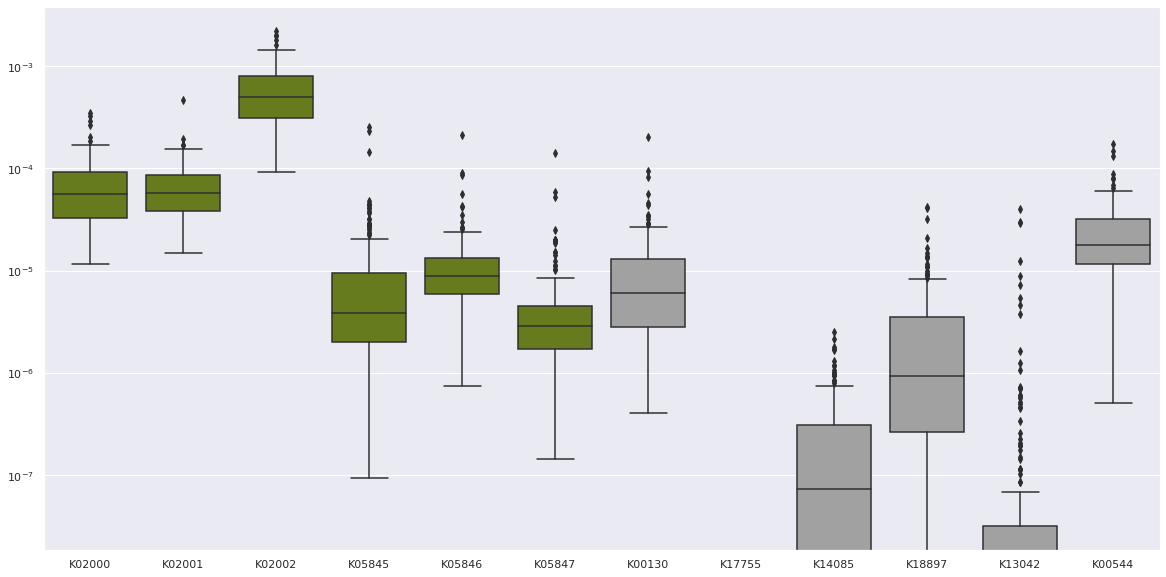

In [864]:
create_box_plot(Tbact_summed, compound='Glycine betaine')

Index(['K00008', 'K19270_x', 'K00007_x', 'K24204_x', 'K00045_x', 'K19270_y',
       'K02798', 'K00007_y', 'K24204_y', 'K00045_y', 'K02800'],
      dtype='object')


,K10111,K10112,K10227,K10228,K10229,K00008,K19270_x,K00007_x,K24204_x,K00045_x,K19270_y,K02798,K00007_y,K24204_y,K00045_y,K02800
TARA_B100000267,0.000005,0.000020,0.000006,1.595816e-07,9.176593e-08,1.127407e-07,0.000000e+00,0.0,1.728483e-07,1.179267e-06,0.000000e+00,3.174953e-07,0.0,1.728483e-07,1.179267e-06,2.388373e-04
TARA_B100000987,0.000013,0.000020,0.000004,3.244205e-07,4.617198e-08,0.000000e+00,0.000000e+00,0.0,1.836221e-08,1.219724e-07,0.000000e+00,0.000000e+00,0.0,1.836221e-08,1.219724e-07,2.464208e-04
TARA_B100000900,0.000018,0.000043,0.000009,2.882477e-07,1.668711e-07,3.080040e-08,0.000000e+00,0.0,5.989055e-07,7.164626e-07,0.000000e+00,0.000000e+00,0.0,5.989055e-07,7.164626e-07,1.179787e-04
TARA_B100000674,0.000007,0.000019,0.000004,2.236507e-07,2.842303e-07,3.623084e-08,0.000000e+00,0.0,3.350908e-07,3.464142e-07,0.000000e+00,0.000000e+00,0.0,3.350908e-07,3.464142e-07,2.708618e-04
TARA_B100000943,0.000011,0.000028,0.000015,3.102395e-06,4.203003e-06,2.647389e-07,0.000000e+00,0.0,0.000000e+00,2.109005e-06,0.000000e+00,1.491610e-06,0.0,0.000000e+00,2.109005e-06,6.857785e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARA_B100000787,0.000002,0.000085,0.000249,5.691210e-06,3.183069e-06,6.731627e-08,0.000000e+00,0.0,1.790581e-07,5.741127e-06,0.000000e+00,1.182317e-08,0.0,1.790581e-07,5.741127e-06,1.857900e-07
TARA_B100000954,0.000010,0.000015,0.000003,5.910719e-08,3.853867e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.559285e-06,0.000000e+00,3.039881e-08,0.0,0.000000e+00,1.559285e-06,8.214479e-06
TARA_B100000929,0.000030,0.000032,0.000104,3.245995e-05,2.269195e-05,9.673444e-09,1.262154e-07,0.0,0.000000e+00,2.282688e-05,1.262154e-07,1.295614e-07,0.0,0.000000e+00,2.282688e-05,2.884083e-06
TARA_B100000090,0.000016,0.000053,0.000042,4.119991e-07,1.180079e-07,0.000000e+00,0.000000e+00,0.0,2.283819e-07,1.183014e-06,0.000000e+00,0.000000e+00,0.0,2.283819e-07,1.183014e-06,9.379466e-05


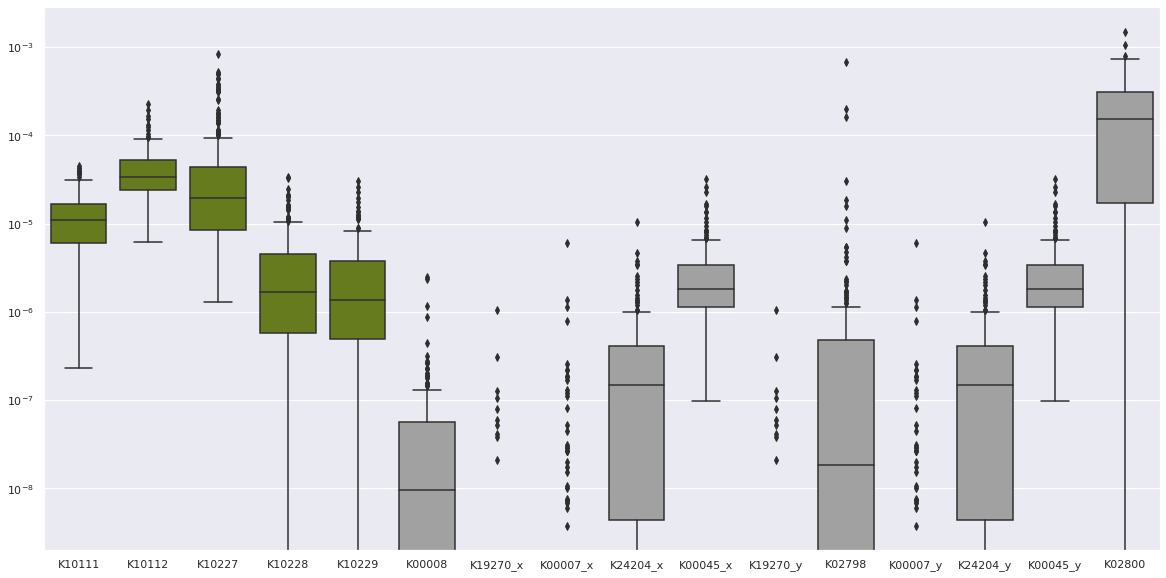

In [865]:
create_box_plot(Tbact_summed, compound='Mannitol')

ValueError: Cannot use `hue` without `x` and `y`

ValueError: min() arg is an empty sequence

In [776]:
tt

,K02000,K02001,K02002,K05845,K05846,K05847,K00130,K17755,K14085,K18897,K13042,K00544
TARA_B100000267,0.000017,0.000026,0.000497,7.389564e-06,0.000008,0.000004,4.067313e-07,0.0,4.486838e-07,4.428186e-07,0.000000e+00,0.000008
TARA_B100000987,0.000032,0.000031,0.000276,6.271061e-07,0.000003,0.000001,4.290216e-07,0.0,6.265865e-09,2.574594e-07,0.000000e+00,0.000018
TARA_B100000900,0.000055,0.000090,0.001087,2.423461e-06,0.000006,0.000001,5.097897e-07,0.0,3.854322e-07,8.500139e-07,1.119762e-07,0.000024
TARA_B100000674,0.000020,0.000033,0.000391,7.538728e-07,0.000005,0.000001,5.611108e-07,0.0,7.503860e-07,1.506345e-06,0.000000e+00,0.000013
TARA_B100000943,0.000026,0.000052,0.000409,4.296538e-06,0.000004,0.000001,5.803048e-07,0.0,0.000000e+00,1.048444e-06,0.000000e+00,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...
TARA_B100000787,0.000110,0.000110,0.001348,8.406983e-07,0.000005,0.000003,4.599792e-05,0.0,6.762299e-08,1.931567e-06,0.000000e+00,0.000013
TARA_B100000954,0.000062,0.000036,0.000332,1.170063e-06,0.000004,0.000002,5.633296e-05,0.0,3.952442e-07,2.043331e-06,0.000000e+00,0.000011
TARA_B100000929,0.000045,0.000030,0.000453,4.856151e-05,0.000025,0.000020,8.338211e-05,0.0,1.556556e-08,2.149240e-06,0.000000e+00,0.000001
TARA_B100000090,0.000145,0.000142,0.000955,6.130616e-06,0.000013,0.000005,9.447701e-05,0.0,1.075215e-06,2.631373e-08,0.000000e+00,0.000049
